# Session 1: Introduction to portfolio management

This notebook contains the scripts which the figures of Session 1: Introduction to Portfolio Management. 

If you want a step-by-step guide, please refer to Tutorial 1 (Moodle). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

os.chdir(r'/Users/christophe/OneDrive - ICHEC/Documents/Cours/PortfolioManagement')

from scripts.utils import compute_portfolio_rets, compute_portfolio_volatility
from scripts.utils import annualize_rets

%load_ext autoreload
%autoreload 2

## S&P500 (daily)

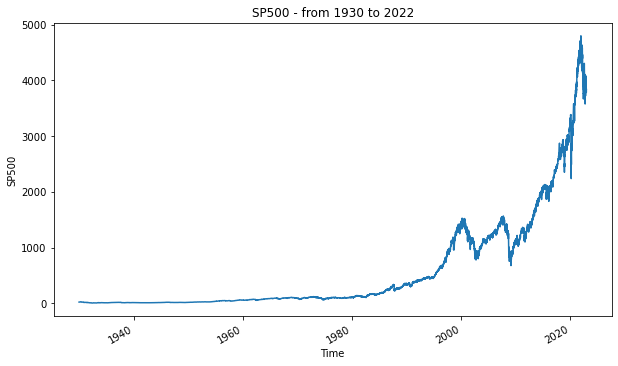

In [2]:
df = pd.read_excel('data/sp500_daily.xlsx', sheet_name='data',
                   parse_dates=True, index_col=0)

fig, ax = plt.subplots(figsize=(10,6))
ax = df['CLOSE'].plot()
plt.title('SP500 - from 1930 to 2022')
plt.xlabel('Time')
plt.ylabel('SP500')
plt.savefig('images/01_sp500.png')
plt.show()

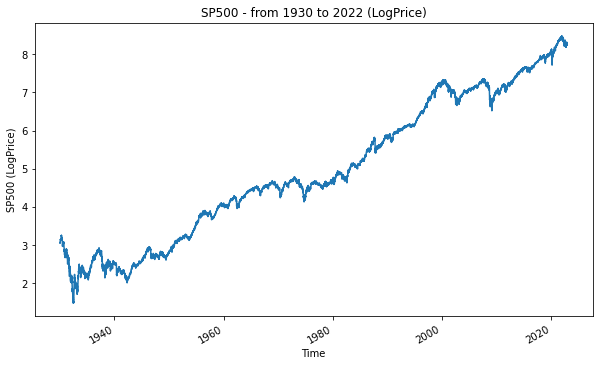

In [3]:
df['LogPrice'] = np.log(df['CLOSE'])
fig, ax = plt.subplots(figsize=(10,6))
ax = df['LogPrice'].plot()
plt.title('SP500 - from 1930 to 2022 (LogPrice)')
plt.xlabel('Time')
plt.ylabel('SP500 (LogPrice)')
plt.savefig('images/01_sp500_log.png')
plt.show()

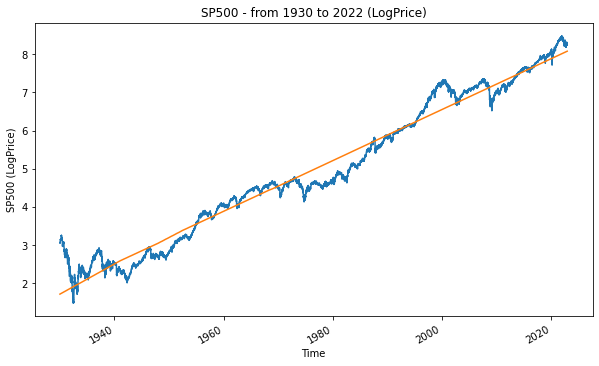

In [4]:
# fit linear trend line 
X = np.arange(1, len(df.index)+1)
Y = np.array(df['LogPrice']).reshape(-1, 1)
X = sm.add_constant(X)
results = sm.OLS(Y,X).fit()
df['Trend'] = results.params @ X.T

fig, ax = plt.subplots(figsize=(10,6))
ax = df['LogPrice'].plot()
ax = df['Trend'].plot()
plt.title('SP500 - from 1930 to 2022 (LogPrice)')
plt.xlabel('Time')
plt.ylabel('SP500 (LogPrice)')
plt.savefig('images/01_sp500_log_trend.png')
plt.show()

### Yearly volatilities

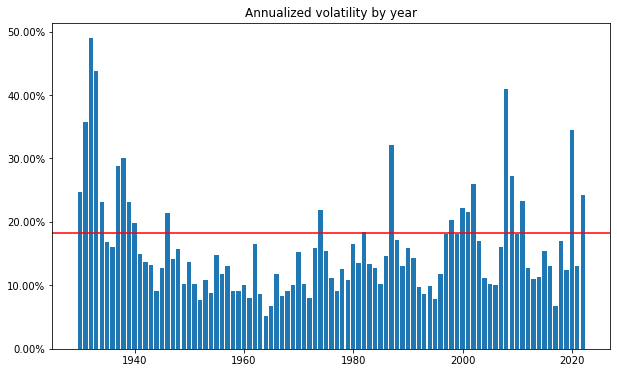

In [5]:
df = pd.read_excel('data/sp500_daily.xlsx', index_col=0, parse_dates=True)
frequency = 252
rets = pd.DataFrame(df['CLOSE'].pct_change().dropna())
mean_vol = rets['CLOSE'].std() * np.sqrt(frequency)
rets['Year'] = rets.index.year
annual_vols = rets.groupby('Year').std() * np.sqrt(frequency)

# plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(annual_vols.index, annual_vols['CLOSE'])
plt.axhline(mean_vol, color='r')
ax.set_title('Annualized volatility by year')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('images/01_annual_volatily.png')
plt.show()

### Rolling volatility

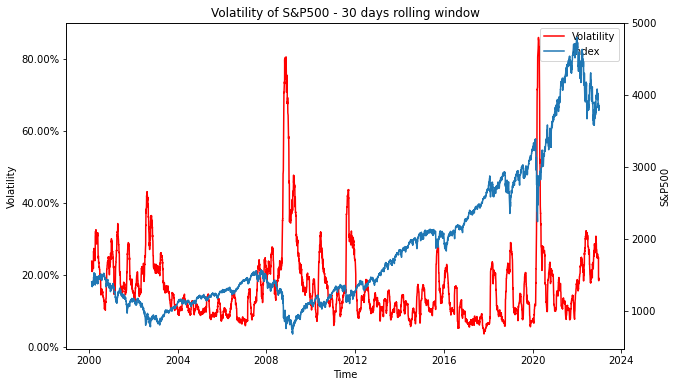

In [6]:
df = pd.read_excel('data/sp500_daily.xlsx', index_col=0, parse_dates=True)
df = df.loc['2000-01-01':]
df.rename(columns={'CLOSE': 'SP500'}, inplace=True)
rets = np.log(df / df.shift(1)).dropna()
window = 30
rol_vol = rets['SP500'].rolling(window).std() * np.sqrt(252)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
line1 = ax.plot(rol_vol.index, rol_vol, color='r', label='Volatility')
ax2 = ax.twinx()
line2 = ax2.plot(df.index[window:], df['SP500'][window:], label='Index')
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)
ax.set_title(f'Volatility of S&P500 - {window} days rolling window')
ax.set_xlabel('Time')
ax.set_ylabel('Volatility')
ax2.set_ylabel('S&P500')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('images/01_rolling_volatility.png')
plt.show()

## DJIA (daily)

In [7]:
prices_daily = pd.read_excel('data/DJIA_daily.xlsx', 
                   sheet_name='prices', 
                   index_col=0, 
                   parse_dates=True)
frequency = 252
rets_daily = prices_daily.pct_change().dropna()
df = prices_daily.iloc[-1] / prices_daily.iloc[0] - 1 
df = pd.DataFrame(df)
df.rename(columns={0: 'HPR'}, inplace=True)
df['AnnualizedRets'] = (df['HPR']+1)**(frequency/rets_daily.shape[0]) - 1
df['AnnualizedVolatility'] = rets_daily.std() * np.sqrt(frequency)
df.head()

,HPR,AnnualizedRets,AnnualizedVolatility
GS.N,0.983938,0.054197,0.291412
NKE.N,6.162050,0.163785,0.276192
CSCO.OQ,0.929526,0.051941,0.267201
JPM.N,2.129522,0.091873,0.285460
DIS.N,1.709074,0.079804,0.260958


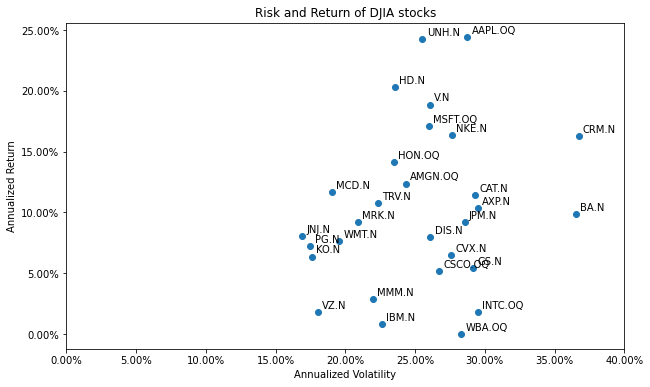

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['AnnualizedVolatility'], df['AnnualizedRets'])
ax.set_xlim((0, 0.4))
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Return')
ax.set_title('Risk and Return of DJIA stocks')

# Loop for annotation of all points
for i in range(df.shape[0]):
    plt.annotate(df.index[i], (df.iloc[i]['AnnualizedVolatility']+0.003, 
                               df.iloc[i]['AnnualizedRets']+0.003))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])

plt.savefig('images/01_risk_return_djia_stocks.png')
plt.show()

## Portfolio: 2 stocks

In [9]:
df = pd.read_excel('data/DJIA_monthly.xlsx', index_col=0, 
                   parse_dates=True, sheet_name='prices')
frequency = 12 
stocks = df.columns[:2]
prices = df[stocks]
rets = prices.pct_change().dropna()
AnnR = annualize_rets(rets, frequency)
weights = np.repeat(1/len(stocks), len(stocks))
portfolio_rets = AnnR @ weights
portfolio_vol = compute_portfolio_volatility(weights, rets)
print('Portfolio return', round(portfolio_rets, 4))
print('Portfolio volatility', round(portfolio_vol, 4))

Portfolio return 0.1169
Portfolio volatility 0.2262


## Portfolio with N stocks

In [10]:
df = pd.read_excel('data/DJIA_monthly.xlsx', index_col=0, 
                   parse_dates=True, sheet_name='prices')
frequency = 12 
stocks = df.columns[:3]
prices = df[stocks]
rets = prices.pct_change().dropna()
AnnR = annualize_rets(rets, frequency)
weights = np.repeat(1/len(stocks), len(stocks))
portfolio_rets = AnnR @ weights
portfolio_vol = compute_portfolio_volatility(weights, rets)
print('Portfolio return', round(portfolio_rets, 4))
print('Portfolio volatility', round(portfolio_vol, 4))

Portfolio return 0.0979
Portfolio volatility 0.21


## Portfolio weights

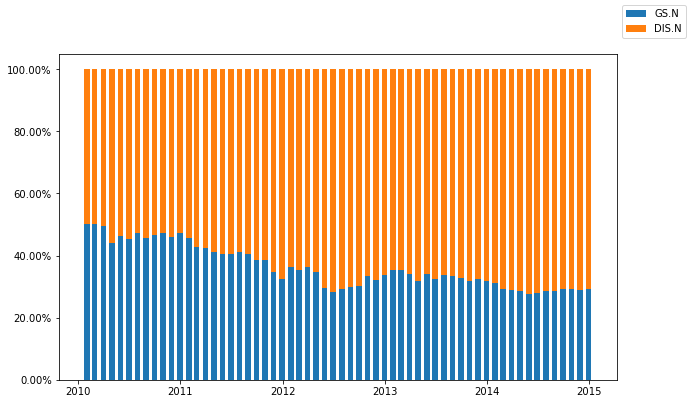

In [11]:
n1 = 20
n2 = 100

stock1 = 'GS.N'
stock2 = 'DIS.N'

start_date = '2010-01-01'
end_date = '2015-01-01'

df = pd.read_excel('data/DJIA_monthly.xlsx', index_col=0, parse_dates=True)
df = df.loc[start_date:end_date]
df = df[[stock1, stock2]]

df['Portfolio'] = n1 * df[stock1] + n2 * df[stock2]
df['w1'] = n1 * df[stock1] / df['Portfolio']
df['w2'] = n2 * df[stock2] / df['Portfolio']

width = 20
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df.index, df['w1'], width=width, label=stock1)
ax.bar(df.index, df['w2'], bottom=df['w1'], width=width, label=stock2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
fig.legend(loc="upper right")
plt.savefig('images/01_weights.png')
plt.show()